## PEP Analysis 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import os
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import cartopy.crs as ccrs

from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
from scipy.sparse.csgraph import shortest_path, dijkstra

from scripts.auxiliar import spherical2cartesian, cartesian2spherical, GCD_cartesian

In [2]:
current_path = os.getcwd() 
data_path_PP = current_path + "/data/poles_NAM"
file_name = "/NAM_poles_0_130.xlsx"

df_NAM = pd.read_excel(data_path_PP + file_name)

# We just analize the results from the first 60Myr
#df_NAM = df_NAM[df_NAM.age < 60]

# We add the cartesian coordinates of the poles
df_NAM["x"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[0], axis=1)
df_NAM["y"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[1], axis=1)
df_NAM["z"] = df_NAM.apply(lambda row: spherical2cartesian(row.slat, row.slon)[2], axis=1)

N = df_NAM.shape[0]  # number of PPs

df_NAM = df_NAM.sort_values(by="age")
df_NAM.head(5)

,ID,name,min_age,max_age,age,slat,slon,N,k,alpha95,...,Euler_lat,Euler_lon,Euler_ang,author,Q,reliability,age constraints,x,y,z
1,2,Michoacan Guanajuato volcanic ﬁeld,0.0,0.6,0.3,19.25,257.67,8,29.0,9.1,...,79.2,23.0,0.2,Maciel Peña et al. (2009),5,NaN,Ar-Ar ages of 82 to 612 ka (from another study),0.919264,0.054671,0.389827
0,1,USGS SW North America composite,0.0,1.0,0.5,36.30,242.13,38,24.7,4.8,...,0.0,0.0,0.0,Mankinen (2008),5,NaN,Brunhes normal chron,-0.166445,-0.038510,-0.985298
2,3,Tequila volcanic ﬁelds,0.1,1.1,0.6,20.46,256.76,17,26.0,7.1,...,79.9,22.7,0.3,Ceja et al. (2006),5,NaN,Ar/Ar ages of 0.115 to 1.13 Ma (from another s...,-0.026142,0.029794,0.999214
3,4,Trans Mexican Volcanic Belt,0.0,2.0,1.0,19.40,260.10,24,47.3,4.3,...,79.9,22.7,0.3,Ruiz-Martínez et al. (2010),5,NaN,all Quaternary rocks (some K-Ar dated),-0.677365,0.517281,0.523066
4,5,Katherine Creek sediments,0.0,3.0,1.5,65.00,232.40,100,9.1,4.9,...,80.8,22.8,0.4,Barendregt et al. (1996),3,NaN,magnetostratigraphy,-0.560750,0.043746,0.826829


We can plot the PPs to see how they look like.

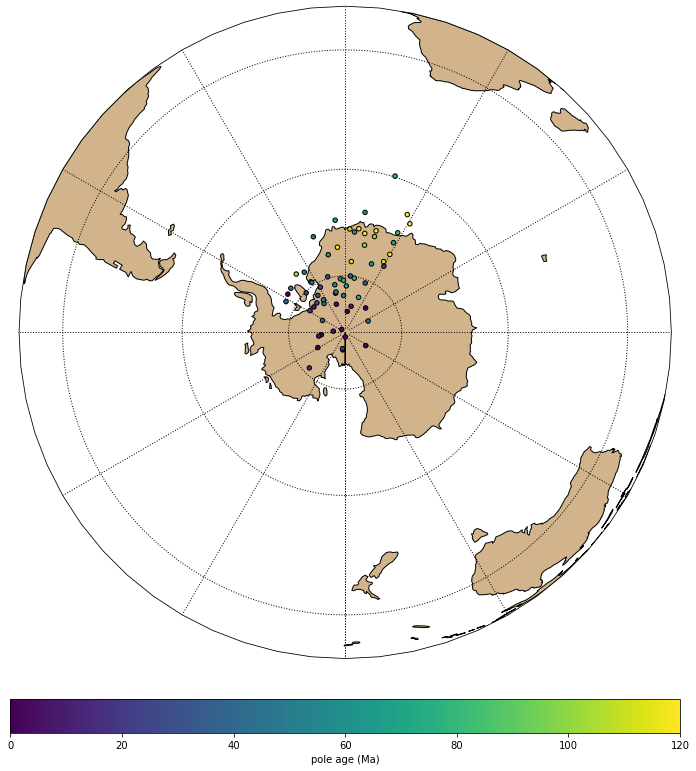

In [3]:
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(15,15))
ipmag.plot_poles_colorbar(map_axis, df_NAM.plon, df_NAM.plat, np.zeros(df_NAM.shape[0]) ,df_NAM.age, 0, 120)
plt.show()

### 1. Analysis based on minimizing path [Gallo et al (2021)]

We start by building the adjacent matrix that we will later use for estimating the optimal APW path. Each entry of `Adj_matrix` has the total cost of moving from one PP to another, where the cost is computed as the minimum of the cost function defined by the sum of the squares of the residuals of a small circle fit.

In [4]:
%%time 

age_min = 5.        # min age difference between change points
n_min = 4           # min number of poles in a single segment

min_apical = 30     # min apical angle
n_initials = 2      # number of iterations

Adj_matrix = np.full((N, N), np.inf)
EPs = np.full((N, N, 3), np.nan, dtype=object)
Apicals = np.full((N, N), np.nan)
Res = {}

for i in range(N):
    
    for j in range(i+n_min, N):   
                
        if df_NAM.loc[j,"age"] < df_NAM.loc[i,"age"] + age_min:
            continue
            
        # We need to define the loss function from zero since it has the PP inside the function        
        X = df_NAM[i:j+1][['x', 'y', 'z']].to_numpy()                       
             
        def loss (v):
            theta, phi, varphi = v[0], v[1], v[2]                   
            res = 0
            pole = spherical2cartesian(theta, phi)
            for k in range(X.shape[0]):
                res += ( np.arccos( np.dot( X[k,:], pole)) - varphi ) ** 2        
            return res
        
        
        best = np.inf        
        for _ in range(n_initials): 
                
            initialGuess = [np.random.uniform(-np.pi/2, np.pi/2), np.random.uniform(0, 2 * np.pi), np.random.uniform(min_apical * (np.pi/180), np.pi / 2)] #set up random initial guess        
            optimum_tmp = minimize(loss, x0 = np.array(initialGuess), method = "CG", options = {'gtol': 1E-10})
                        
            if optimum_tmp.fun < best and optimum_tmp.x[-1] > min_apical * (np.pi/180): 
                optimum = optimum_tmp
                best = optimum_tmp.fun
                
        if best < np.inf:      
            Adj_matrix[i,j] = optimum.fun
            EPs[i,j,:] = spherical2cartesian(optimum.x[0], optimum.x[1])
            Apicals[i,j] = optimum.x[2] 
            Res[(i,j)] = {"EP_cartesian": EPs[i,j,:], "apical": Apicals[i,j], "EP_polar": [optimum.x[0], optimum.x[1]]}

CPU times: user 2min 4s, sys: 485 ms, total: 2min 5s
Wall time: 2min 5s


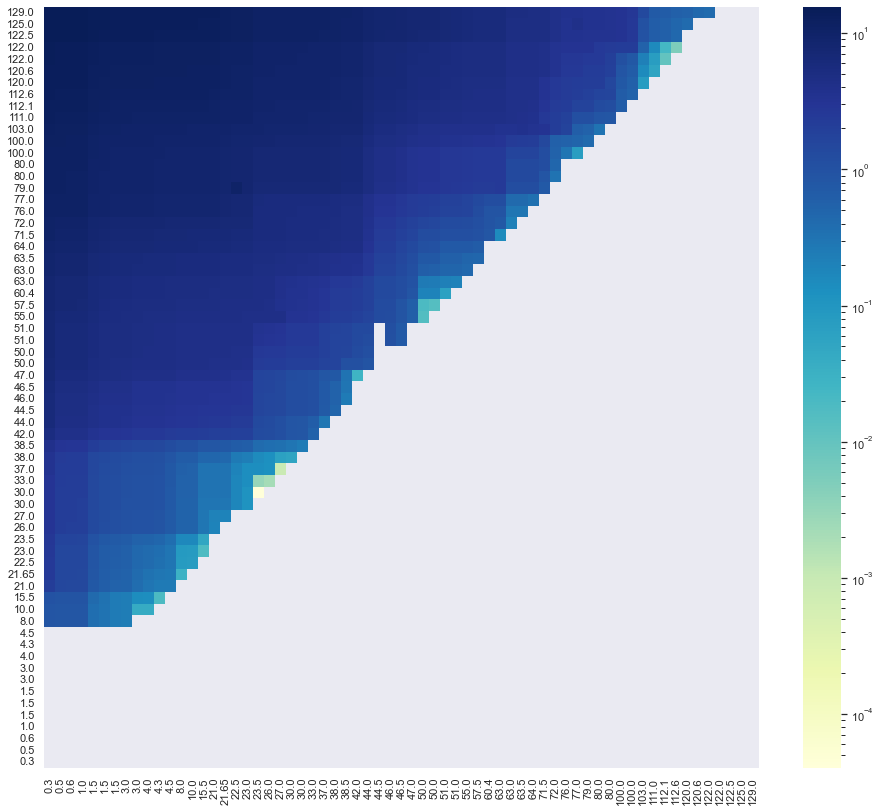

In [5]:
Adj_matrix_df = pd.DataFrame(Adj_matrix.transpose())
sns.set(rc={'figure.figsize':(16,14)})

sns.heatmap(Adj_matrix_df, cmap="YlGnBu", robust=True, norm=LogNorm(), xticklabels=df_NAM.age, yticklabels=df_NAM.age).invert_yaxis()

Now we search for the optimal path using Dijkstra algorithm for differnt values of the regularization parameter lambda. For each lambda, we are going to obtain a different number of segments and changepoints that we can store and then compare to see if we can define the optimal number of paths and its respective segments. 

In [7]:
def get_changepoints(Adj_matrix, reg = 0.0001):
    '''
    Given the Adjacency matrix and the regularization parameter, returns a list with changepoints along with the distance matrix
    '''    
    
    Adj_matrix_reg = Adj_matrix + reg
    
    dist_matrix, predecesors = shortest_path(Adj_matrix_reg, 
                                             return_predecessors = True)
    
    res = []
    x = predecesors[0, -1]
    
    while x != 0:
        
        res.append(x)
        x = predecesors[0, x]
        
    return list(reversed(res)), dist_matrix[0,-1]

In [8]:
N_lamb = 1000

all_lamb_log = np.linspace(-1, 1, N_lamb)
all_lamb = 10 ** all_lamb_log

all_cost, all_nsegments = [], []
AICs = []
BICs = []

Tree = np.full((N, N_lamb), 0)
Tree_lamb = []
Tree_age = []

for i, lamb in enumerate(all_lamb):    
    
    
    changepoints, total_cost = get_changepoints(Adj_matrix, reg=lamb)
    #print(changepoints)
    
    for x in changepoints:
        Tree[x, i] = 1
        Tree_lamb.append(np.log10(lamb))
        Tree_age.append(df_NAM.age[x])
    
    loss_reg = lamb * (len(changepoints) + 1) 
    #loss_reg = lamb * len(changepoints)
    cost_SQ = total_cost - loss_reg 
    
    degree_freedom = 3 * (len(changepoints)+1) + len(changepoints)
    
    all_nsegments.append(len(changepoints)+1)
    all_cost.append(total_cost)
    
    # Alkaline Information Criterion
    AIC = 2*degree_freedom + N * np.log(cost_SQ)
    # corrected AIC
    #AICc = AIC + ( 2*(degree_freedom**2) + 2*degree_freedom ) / (N - degree_freedom - 1)    
    
    AICs.append(AIC)
    
    # Bayesian Information Criterion 
    BIC = degree_freedom * np.log(N) + N * np.log(cost_SQ)
    BICs.append(BIC)

We can plot the location of the different changepoints for different values of lambda. This will give us a cascade of where to locate the changepoints for each lambda and how they increase and we increase the model complexity. Smaller values of lambda are associated to a larger model complexity, ie, more parameters. 

<AxesSubplot:>

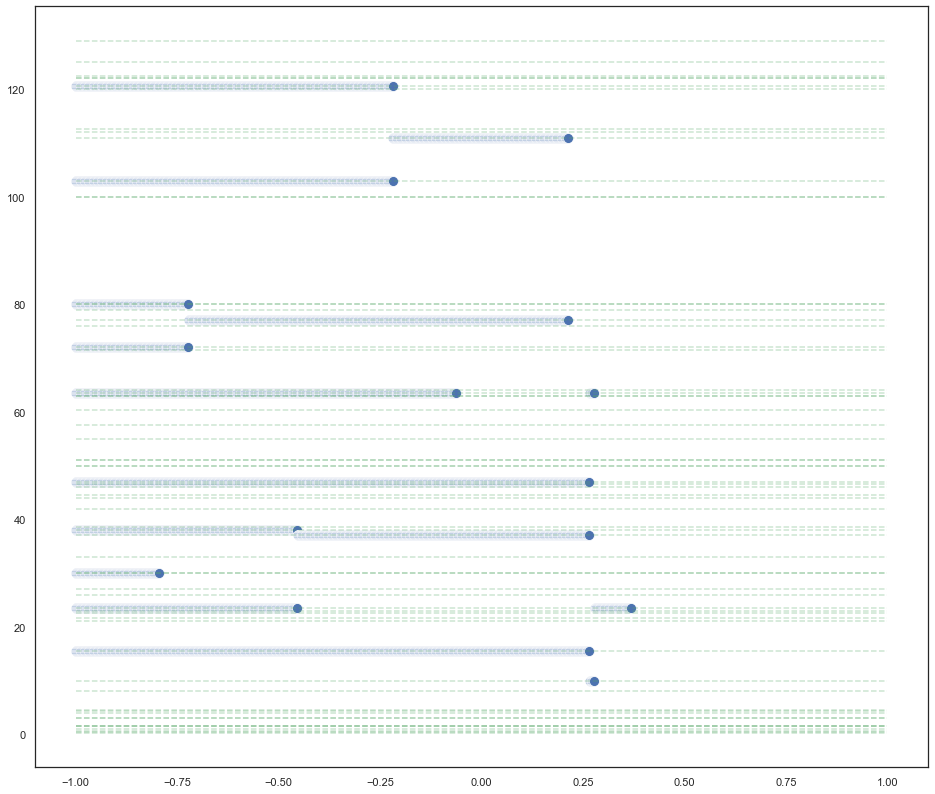

In [9]:
sns.set_style("white")
plt.hlines(y=df_NAM.age.values, xmin=all_lamb_log[0], xmax=all_lamb_log[-1], color='g', linestyle='--', alpha=.3)
sns.scatterplot(x=Tree_lamb, y=Tree_age, s=100, alpha=1)

7

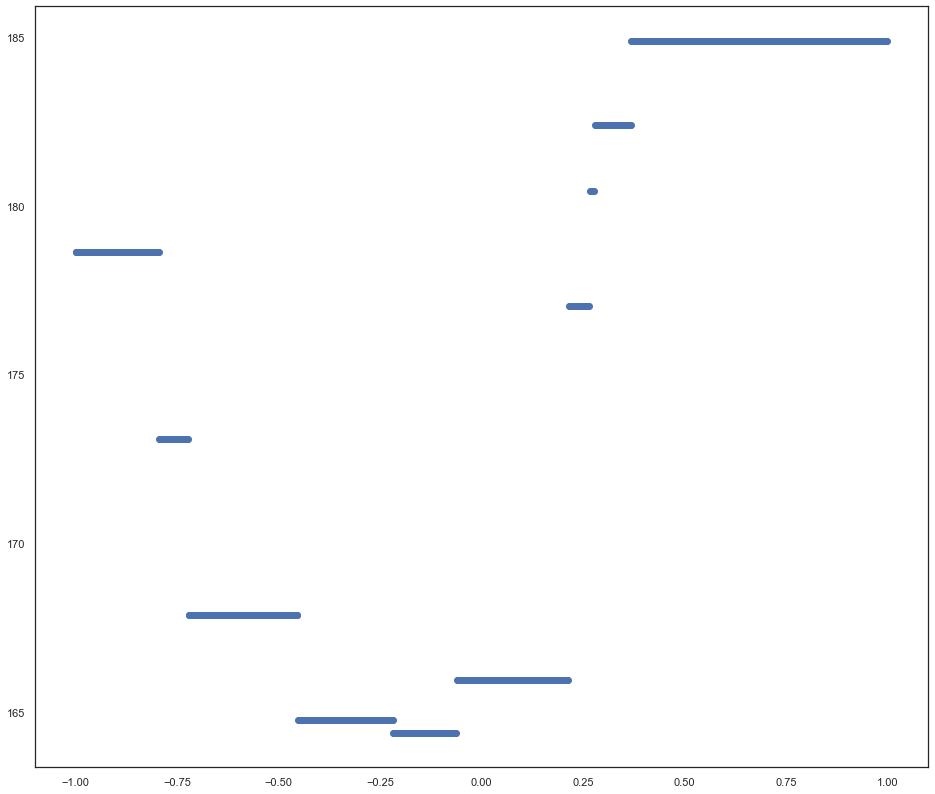

In [10]:
plt.scatter(all_lamb_log, AICs)
all_nsegments[ np.argmin(AICs) ]

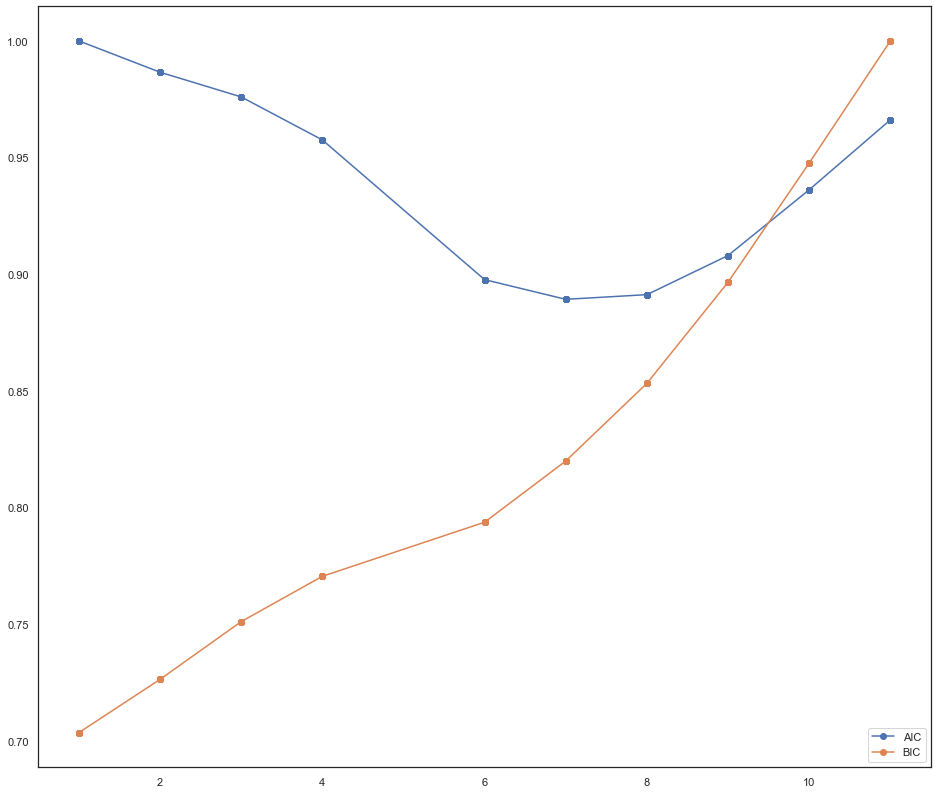

In [19]:
plt.plot(all_nsegments, AICs / np.max(AICs), 'o-', label="AIC")
plt.plot(all_nsegments, BICs / np.max(BICs), 'o-', label="BIC")
plt.legend()

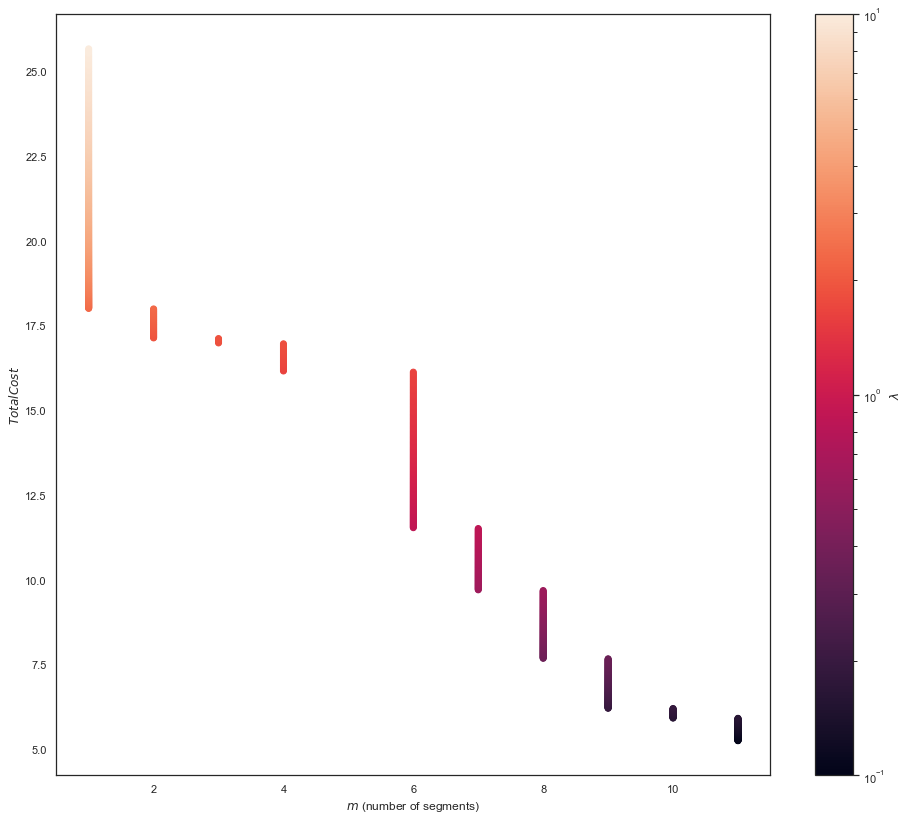

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.scatter(all_nsegments,all_cost,c=all_lamb, norm=LogNorm())
plt.ylabel('$Total Cost$', size = 12)
plt.xlabel('$m$ (number of segments)', size = 12)
#plt.yscale('log')
plt.colorbar(label = '$\lambda$')
plt.savefig('elbow.pdf', dpi =600)
plt.show()

### 2. [Ongoing] Fitting one single rotation

In [125]:
from scipy.spatial.transform import Rotation as rotation

df = df_NAM[df_NAM.age < 60]
df.head()

,ID,name,min_age,max_age,age,slat,slon,N,k,alpha95,...,Euler_lat,Euler_lon,Euler_ang,author,Q,reliability,age constraints,x,y,z
1,2,Michoacan Guanajuato volcanic ﬁeld,0.0,0.6,0.3,19.25,257.67,8,29.0,9.1,...,79.2,23.0,0.2,Maciel Peña et al. (2009),5,NaN,Ar-Ar ages of 82 to 612 ka (from another study),0.919264,0.054671,0.389827
0,1,USGS SW North America composite,0.0,1.0,0.5,36.30,242.13,38,24.7,4.8,...,0.0,0.0,0.0,Mankinen (2008),5,NaN,Brunhes normal chron,-0.166445,-0.038510,-0.985298
2,3,Tequila volcanic ﬁelds,0.1,1.1,0.6,20.46,256.76,17,26.0,7.1,...,79.9,22.7,0.3,Ceja et al. (2006),5,NaN,Ar/Ar ages of 0.115 to 1.13 Ma (from another s...,-0.026142,0.029794,0.999214
3,4,Trans Mexican Volcanic Belt,0.0,2.0,1.0,19.40,260.10,24,47.3,4.3,...,79.9,22.7,0.3,Ruiz-Martínez et al. (2010),5,NaN,all Quaternary rocks (some K-Ar dated),-0.677365,0.517281,0.523066
4,5,Katherine Creek sediments,0.0,3.0,1.5,65.00,232.40,100,9.1,4.9,...,80.8,22.8,0.4,Barendregt et al. (1996),3,NaN,magnetostratigraphy,-0.560750,0.043746,0.826829


In [261]:
Lat = df.slat * (np.pi / 180)
Lon = df.slon * (np.pi / 180)
Age = df.age

def loss_rotation(v):
    
    EP_lon, EP_lat, omega, PP_lon_0, PP_lat_0 = v
    
    epole = spherical2cartesian(EP_lon, EP_lat)
    ppole = spherical2cartesian(PP_lon_0, PP_lat_0)
    
    cost = 0
    
    for i,t in enumerate(Age):
        
        dt = omega * t
        r = rotation.from_rotvec(dt * np.array(epole))
    
        rotated_pole = r.apply(ppole)
        ppole = spherical2cartesian(Lon[i], Lat[i])
        
        cost += np.arccos( np.dot(ppole, rotated_pole) ) ** 2
    
    return cost

In [262]:
initialGuess = [np.random.uniform(0, 2*np.pi), np.random.uniform(-np.pi/2, np.pi/2), 1, Lon[0], Lat[0]]
Bounds = [(0, 2*np.pi), (-np.pi/2, np.pi/2), (0,1), (0, 2*np.pi), (-np.pi/2, np.pi/2)]

optimum = minimize(loss_rotation, x0=np.array(initialGuess), method="Nelder-Mead", bounds=Bounds, options={'gtol': 1E-10})
optimum

 final_simplex: (array([[1.263615874548238, 0.627197965170617, 1.               ,
        4.230580510340159, 0.519461440682631],
       [1.263621883483011, 0.627196644241139, 1.               ,
        4.230543679047114, 0.51944939893805 ],
       [1.263617318482994, 0.627205772829847, 1.               ,
        4.230540858974429, 0.519426531115357],
       [1.263621919478077, 0.627189268850457, 1.               ,
        4.23053254122115 , 0.519491473260507],
       [1.263619218690949, 0.62721256936321 , 1.               ,
        4.230578508926206, 0.519503354447798],
       [1.263617731795947, 0.627192061463901, 1.               ,
        4.230534109664132, 0.519554473851017]]), array([3.788637001735601, 3.788637002292162, 3.788637002814164,
       3.78863700365704 , 3.788637005162162, 3.788637005330824]))
           fun: 3.7886370017356006
       message: 'Optimization terminated successfully.'
          nfev: 339
           nit: 209
        status: 0
       success: True
         

In [263]:
EP_lon, EP_lat, omega, PP_lon_0, PP_lat_0  = optimum.x

EP_lon *= (180 / np.pi)
EP_lat *= (180 / np.pi)

PP_lon_0 *= (180 / np.pi)
PP_lat_0 *= (180 / np.pi)

EP_lon, EP_lat, omega

(72.39985653734654, 35.93579632346954, 1.0)

In [264]:
def print_rotated(v):
    
    EP_lon, EP_lat, omega, PP_lon_0, PP_lat_0 = v
    
    epole = spherical2cartesian(EP_lon, EP_lat)
    ppole = spherical2cartesian(PP_lon_0, PP_lat_0)
    
    res = []
    
    for i,t in enumerate(Age):
        
        dt = omega * t
        r = rotation.from_rotvec(dt * np.array(epole))
    
        rotated_pole = r.apply(ppole)
        ppole = spherical2cartesian(Lon[i], Lat[i])
        
        res.append(cartesian2spherical(ppole[0], ppole[1], ppole[2]))
    
    return res

Pred = (180 / np.pi) * np.array(print_rotated(optimum.x))
Pred.shape

(40, 2)

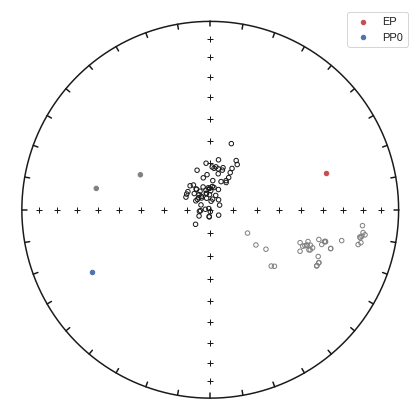

In [265]:
plt.figure(num=0,figsize=(6,6))
ipmag.plot_net(0)


#map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(15,15))
#ipmag.plot_poles_colorbar(map_axis, df_NAM.plon, df_NAM.plat, np.zeros(df_NAM.shape[0]) ,df_NAM.age, 0, 120)
ipmag.plot_di(df_NAM.plon, df_NAM.plat)
ipmag.plot_di(EP_lon, EP_lat, color='r', label="EP")
ipmag.plot_di(PP_lon_0, PP_lat_0, color='b', label="PP0")
ipmag.plot_di(Pred[:,0], Pred[:,1], color='grey')

plt.legend()
plt.show()